In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
import matplotlib.animation as animation
from sklearn.model_selection import train_test_split
from osgeo import gdal
from IPython.display import HTML
from base64 import b64encode
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
from matplotlib import colors 

2023-10-13 14:43:45.152994: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-13 14:43:45.154315: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-13 14:43:45.175746: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-13 14:43:45.175772: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-13 14:43:45.175792: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

In [2]:
df = pd.read_json('./dataSet_Culture_06102023-POINT.json')

In [3]:
df2 = df.copy()
df2['polygon_x'] = df['polygon'].apply(lambda x: x['x'])
df2['polygon_y'] = df['polygon'].apply(lambda x: x['y'])
df2['month'] = df['Analysis Date'].apply(lambda x: x.split('-')[1])
df2['day'] = df['Analysis Date'].apply(lambda x: x.split('-')[2])
df2['vegetation'] = (df['indextype'] == 'NDVI') & (df['averagevalue'] >= 0.15)
df2 = df2.drop(['polygon', 'soil_id'] , axis = 1)
df2['combined'] = df2['polygon_x'].astype(str) + '_' + df2['polygon_y'].astype(str).astype(str)
# Assign unique ID based on the grouped column
df2['field_id'] = df2.groupby('combined').ngroup() + 1
# Drop the combined column
df2 = df2.drop(columns=['combined','polygon_x','polygon_y'])

In [4]:
df2 = df2[df2['indextype'] == 'NDVI']

In [5]:
df2 = df2.drop(columns=['indextype', 'district_name', 'soil_name', 'elevation_contour', 'year contour', 'month', 'day', 'vegetation', 'type_culture_name'])

In [6]:
df2 = df2.rename(columns={'field_id': 'id'})

In [7]:
df2 = df2.rename(columns={'culture_name': 'class'})

In [8]:
df2 = df2.rename(columns={'averagevalue': 'red'})

In [9]:
df2 = df2.rename(columns={'Analysis Date': 'date'})

In [10]:
df2['date'] = pd.to_datetime(df2['date'])

In [11]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5698 entries, 0 to 22927
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   red     5698 non-null   float64       
 1   date    5698 non-null   datetime64[ns]
 2   class   5698 non-null   object        
 3   id      5698 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 222.6+ KB


In [12]:
culture_names = df2['class'].unique()

In [13]:

# Creating the mapping from culture names to integers
culture_to_int = {name: i for i, name in enumerate(culture_names)}

# Creating the reverse mapping from integers to culture names
int_to_culture = {i: name for name, i in culture_to_int.items()}

print(culture_to_int)

{'Картофель': 0, 'Соя': 1, 'Ячмень': 2, 'Кукуруза': 3, 'Пшеница': 4, 'Свекла': 5, 'Люцерна': 6, 'Яровой': 7, 'Фасоль': 8, 'Клевер': 9, 'Арбуз': 10, 'Лук': 11, 'Томат': 12, 'Морковь': 13, 'Рапс': 14, 'Помидор': 15, 'Софлор': 16, 'Сил': 17, 'Лук-Морковка': 18, 'Капуста': 19, 'Экпарцет': 20, 'Подсолнечник': 21}


In [14]:
df2['class'] = df2['class'].map(culture_to_int)

In [15]:
df2['class'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21])

In [16]:
classe_info = {
  'Картофель':                {'value':0, 'color': '#000000'},
  'Соя':                      {'value':1, 'color': '#ffe32e'},
  'Ячмень':                   {'value':2, 'color': '#FF0000'},
  'Кукуруза':                 {'value':3, 'color': '#0000FF'},
  'Пшеница':                  {'value':4, 'color': '#75781f'},
  'Свекла':                   {'value':5, 'color': '#e5eb34'},
  'Люцерна':                  {'value':6, 'color': '#ff24e5'},
  'Яровой':                   {'value':7, 'color': '#a80a96'},
  'Фасоль':                   {'value':8, 'color': '#fa73eb'},
  'Клевер':                   {'value':9, 'color': '#c75e0e'},
  'Арбуз':                    {'value':10, 'color': '#fff68f'},
  'Лук':                      {'value':11, 'color': '#c9cf91'},
  'Томат':                    {'value':12, 'color': '#12e362'},
  'Морковь':                  {'value':13, 'color': '#12e362'},
  'Рапс':                     {'value':14, 'color': '#f77159'},
  'Помидор':                  {'value':15, 'color': '#5e2e10'},
  'Софлор':                   {'value':16, 'color': '#12e0e3'},
  'Сил':                      {'value':17, 'color': '#a9b0b0'},
  'Лук-Морковка':             {'value':18, 'color': '#12e362'},
  'Капуста':                  {'value':19, 'color': '#17e362'},
  'Экпарцет':                 {'value':20, 'color': '#18e362'},
  'Подсолнечник':             {'value':21, 'color': '#22e362'},
}
classes = {x : y.get('value') for x, y in classe_info.items()}
classe_colors = [y.get('color') for x, y in classe_info.items()]
features = ['red']
n_features = len(features)

sequence_size = 30

model_dir = './logs'


In [17]:
df2['class_name'] = df2.apply(lambda row: list(classes.keys())[list(classes.values()).index(row['class'])], axis = 1) 
df2['date'] = pd.to_datetime(df2['date'])
df2.head()

,red,date,class,id,class_name
0,0.217,2020-06-04,0,346,Картофель
1,0.215,2020-08-03,0,346,Картофель
2,0.150,2020-09-02,0,346,Картофель
3,0.052,2021-04-10,0,346,Картофель
4,0.056,2021-05-05,0,346,Картофель


In [18]:
df2 = df2[df2['date'] >= '2022-01-01']

In [25]:
points = df2[df2['class_name'] == 'Картофель'].id.unique()

In [27]:
points

array([346, 349, 347, 348, 343, 345, 344, 281, 279, 280, 177, 178, 179,
       219, 218, 213, 211])

In [30]:
df2

,red,date,class,id,class_name
9,0.033,2022-04-05,0,346,Картофель
10,0.086,2022-05-10,0,346,Картофель
11,0.192,2022-06-14,0,346,Картофель
12,0.092,2022-08-03,0,346,Картофель
13,0.084,2022-09-02,0,346,Картофель
...,...,...,...,...,...
22923,0.192,2022-05-08,3,267,Кукуруза
22924,0.234,2022-06-07,3,267,Кукуруза
22925,0.157,2022-07-02,3,267,Кукуруза
22926,0.163,2022-08-01,3,267,Кукуруза


In [31]:
df2[df2['id']== 346]['red']

9     0.033
10    0.086
11    0.192
12    0.092
13    0.084
Name: red, dtype: float64

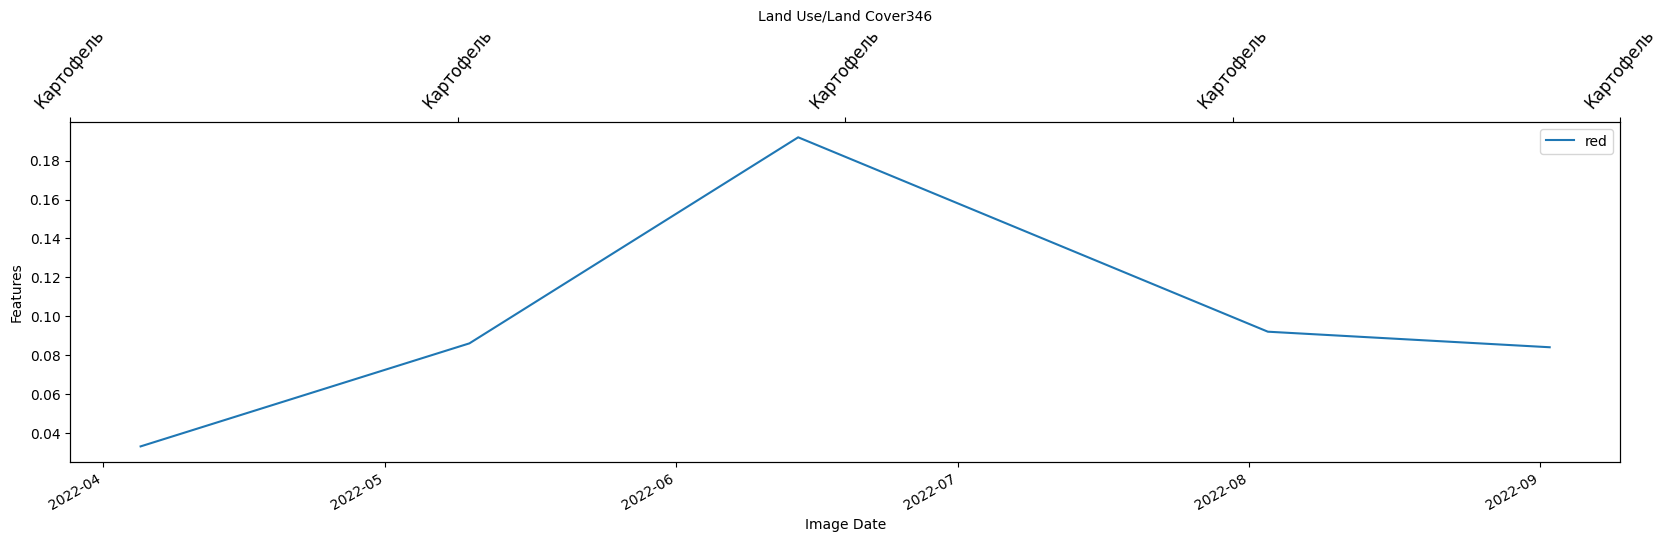

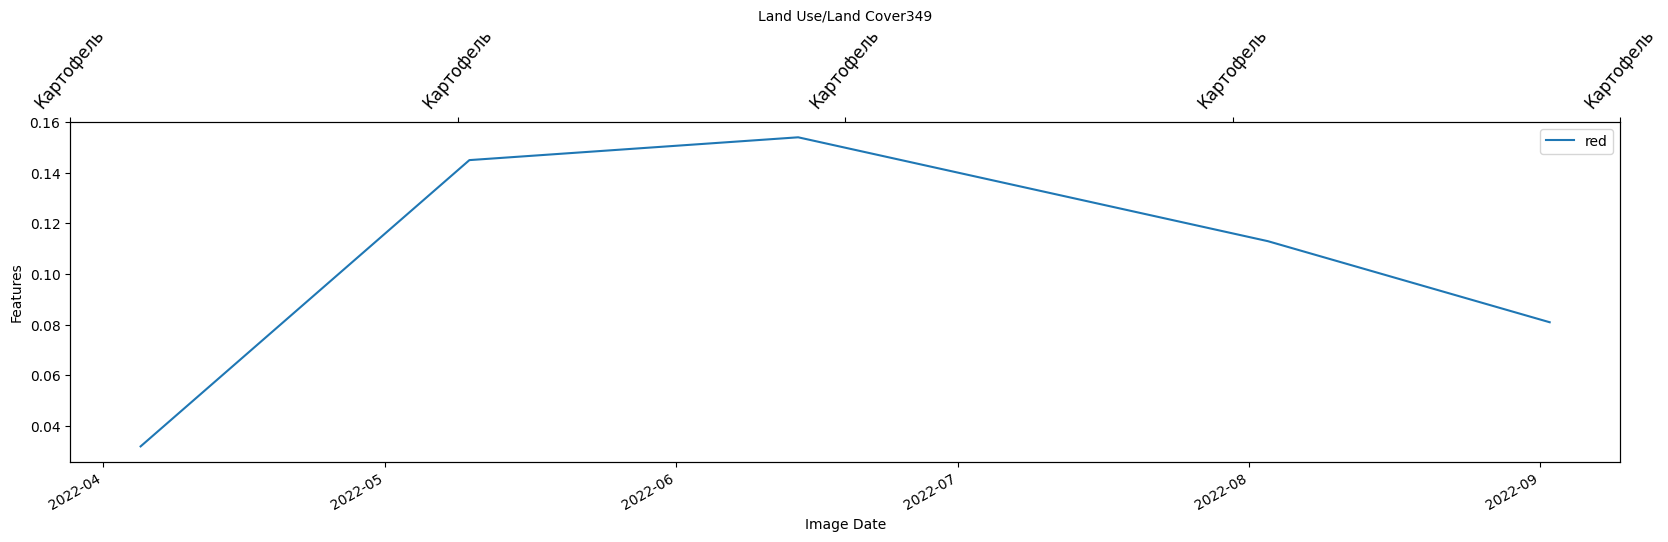

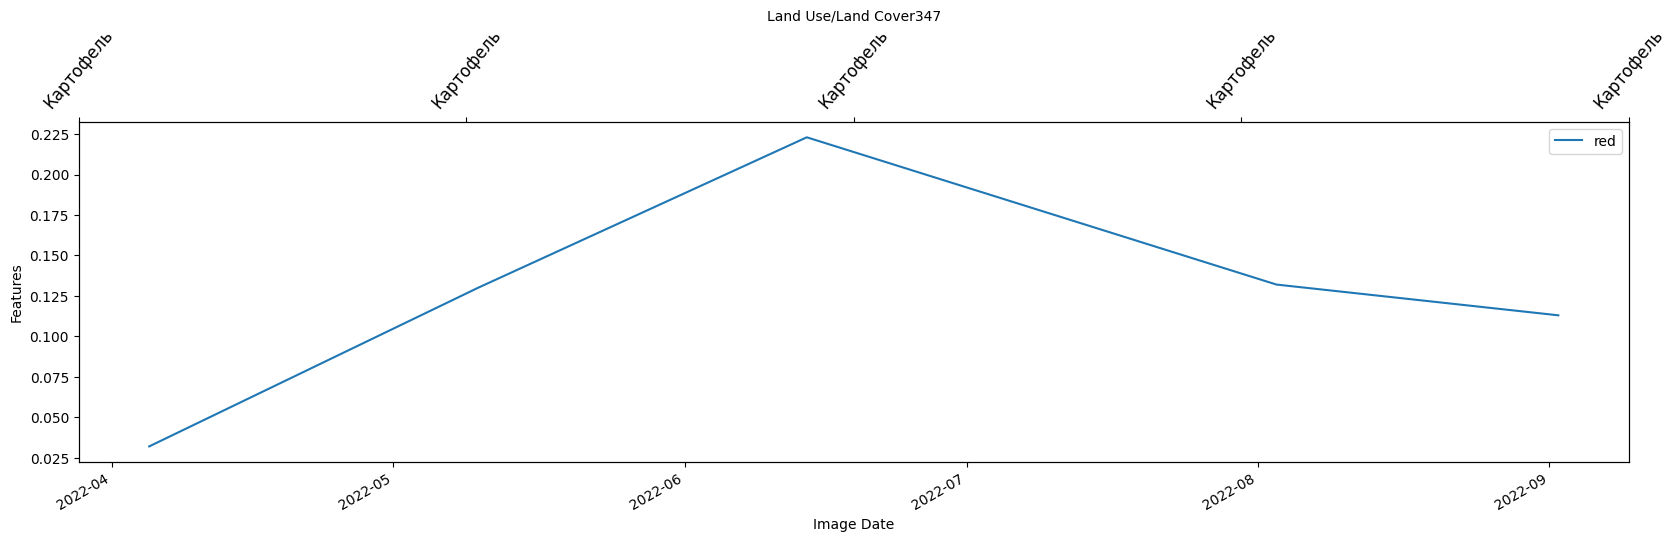

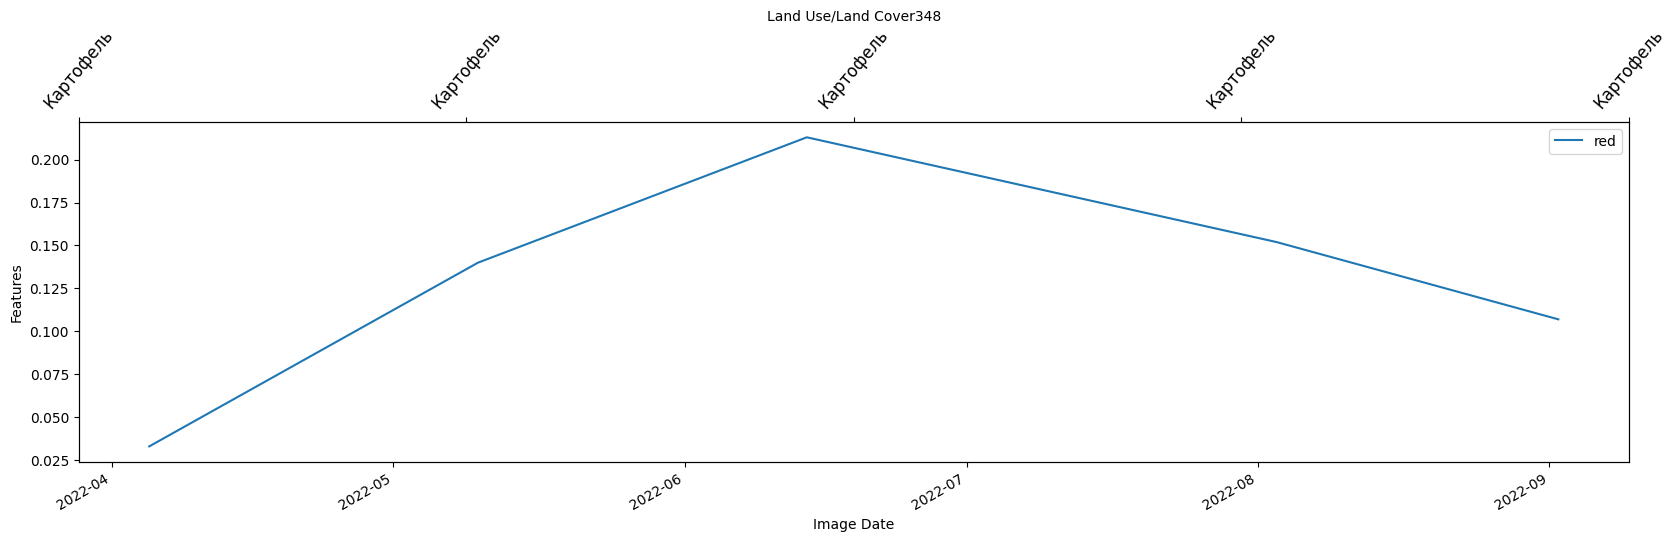

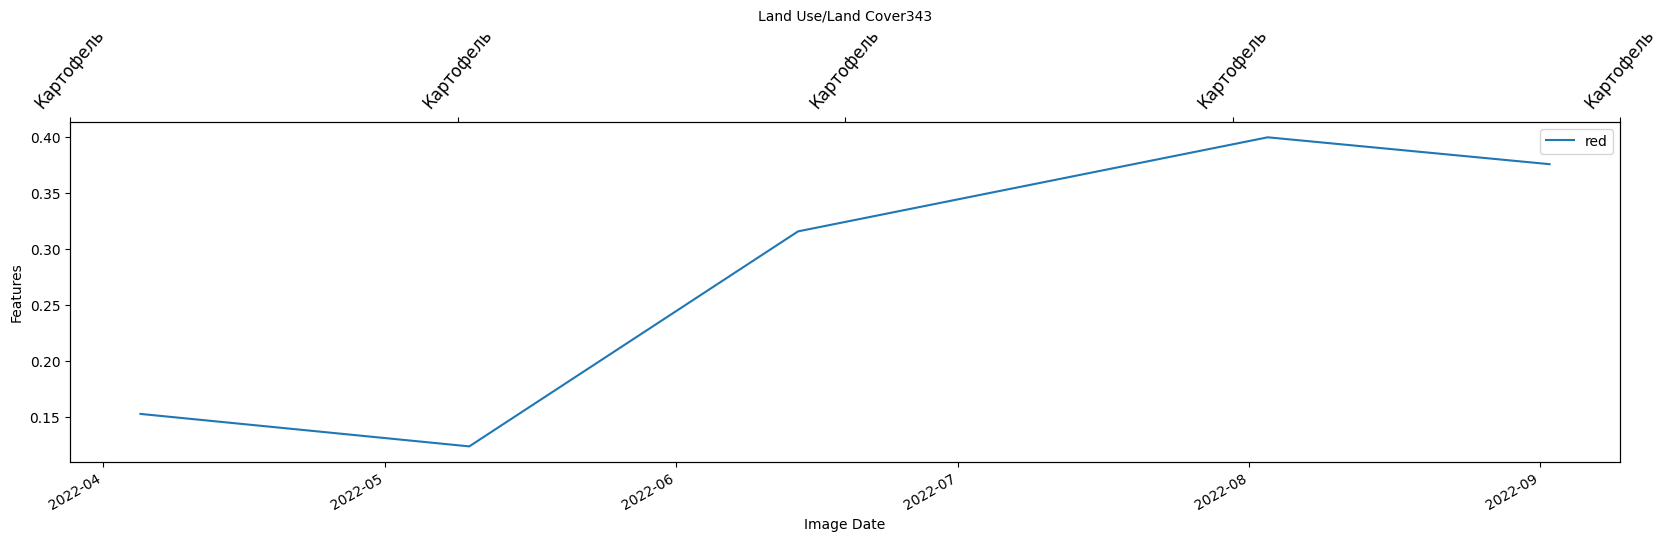

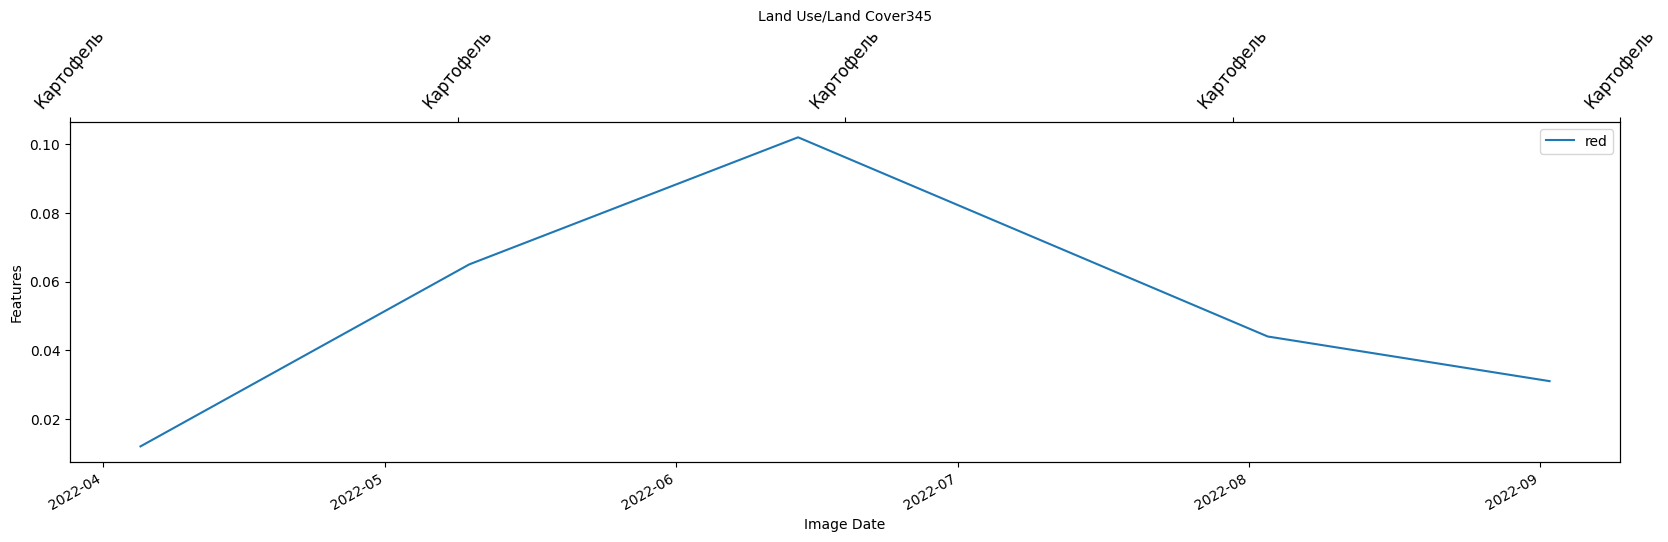

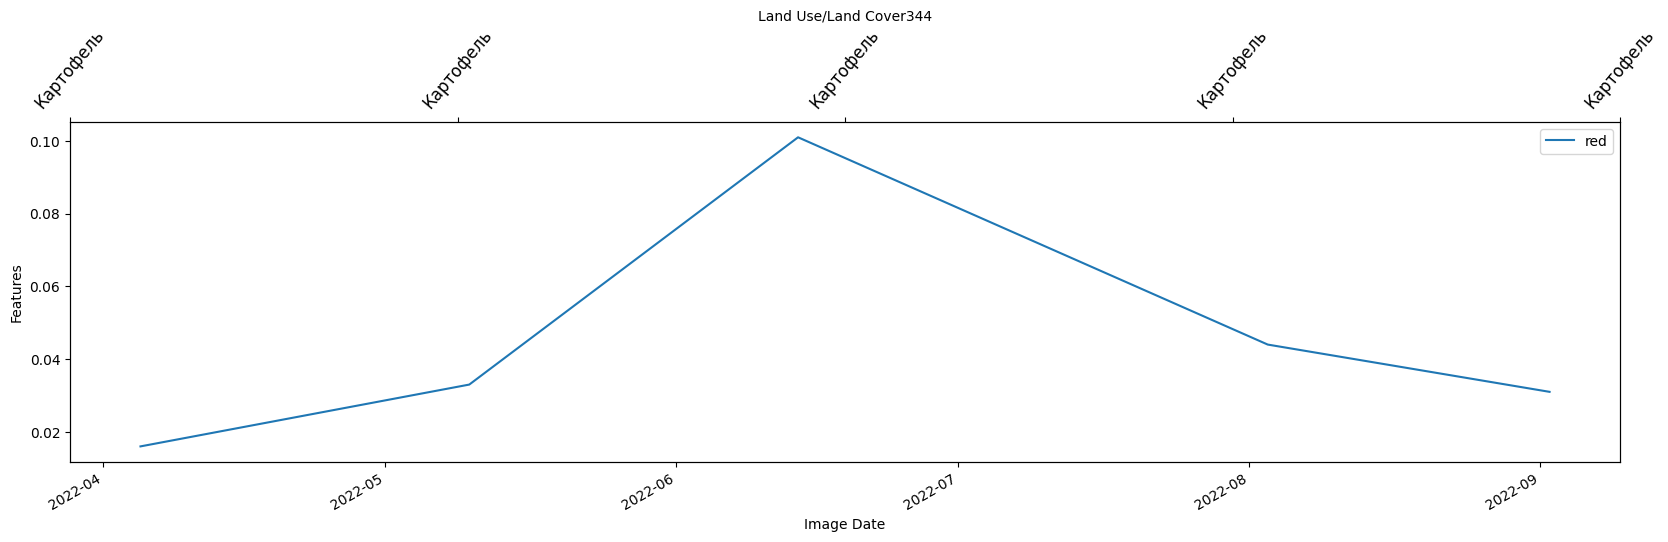

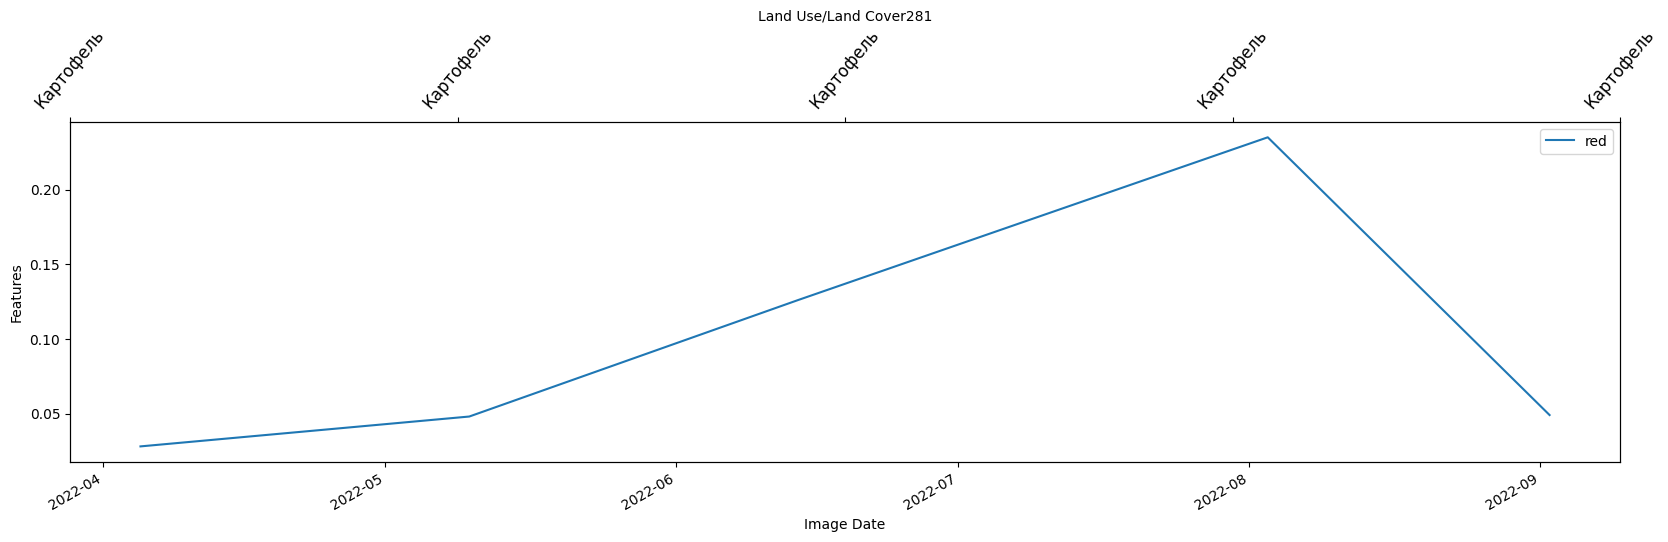

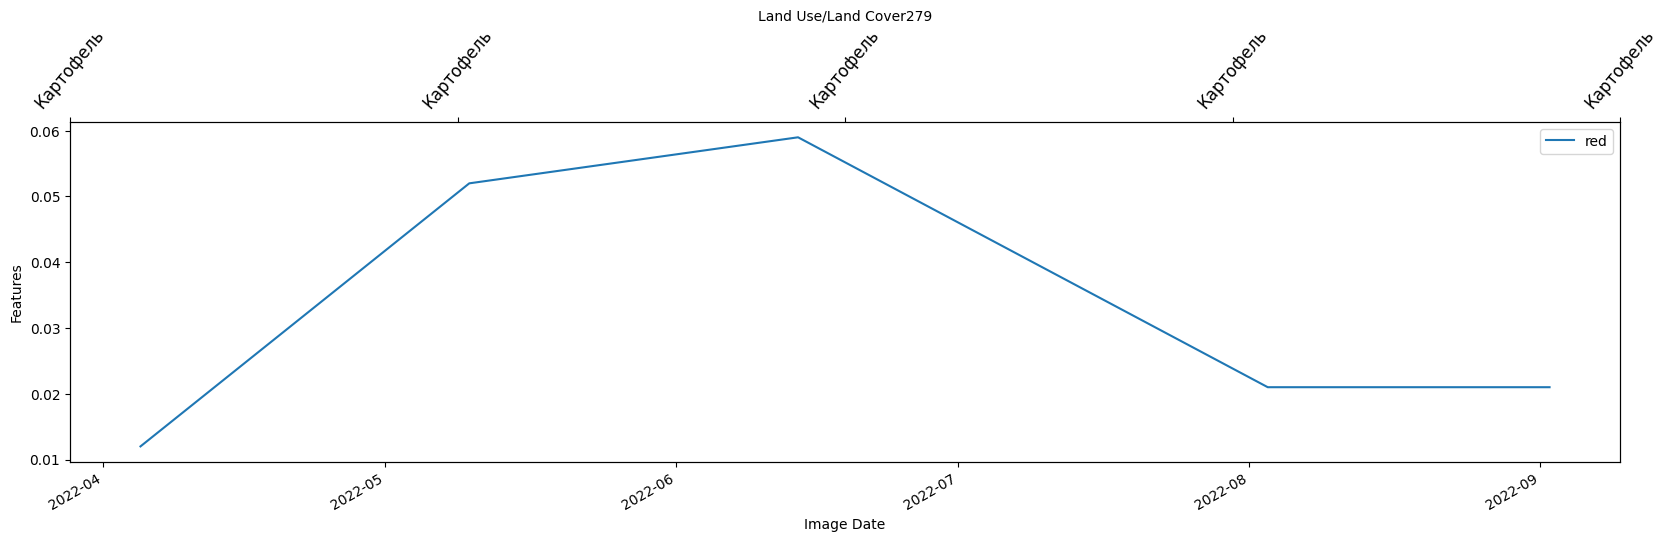

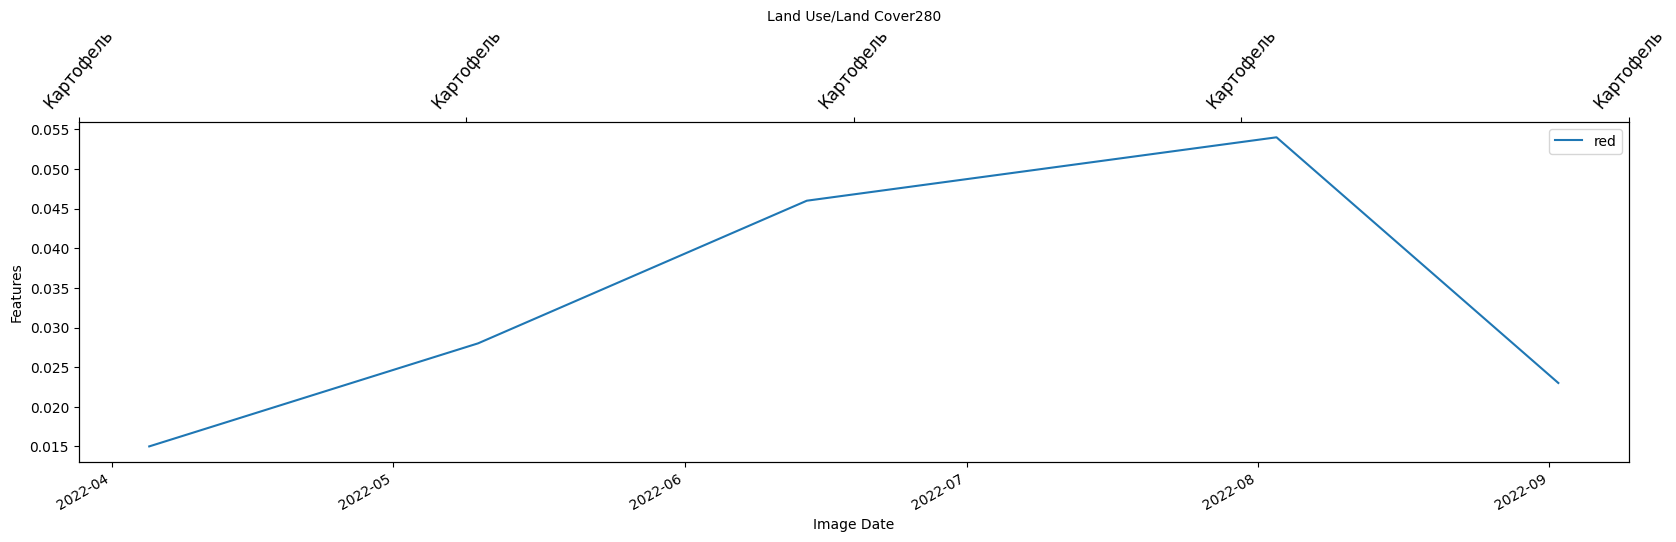

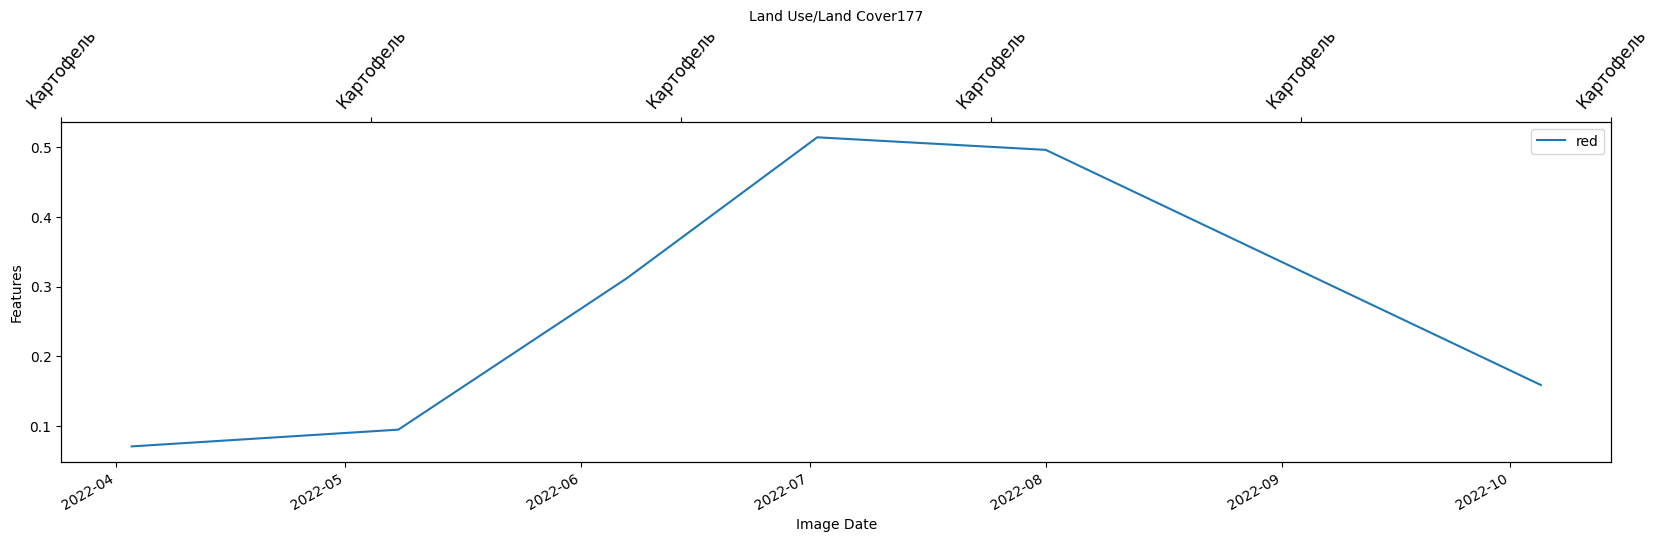

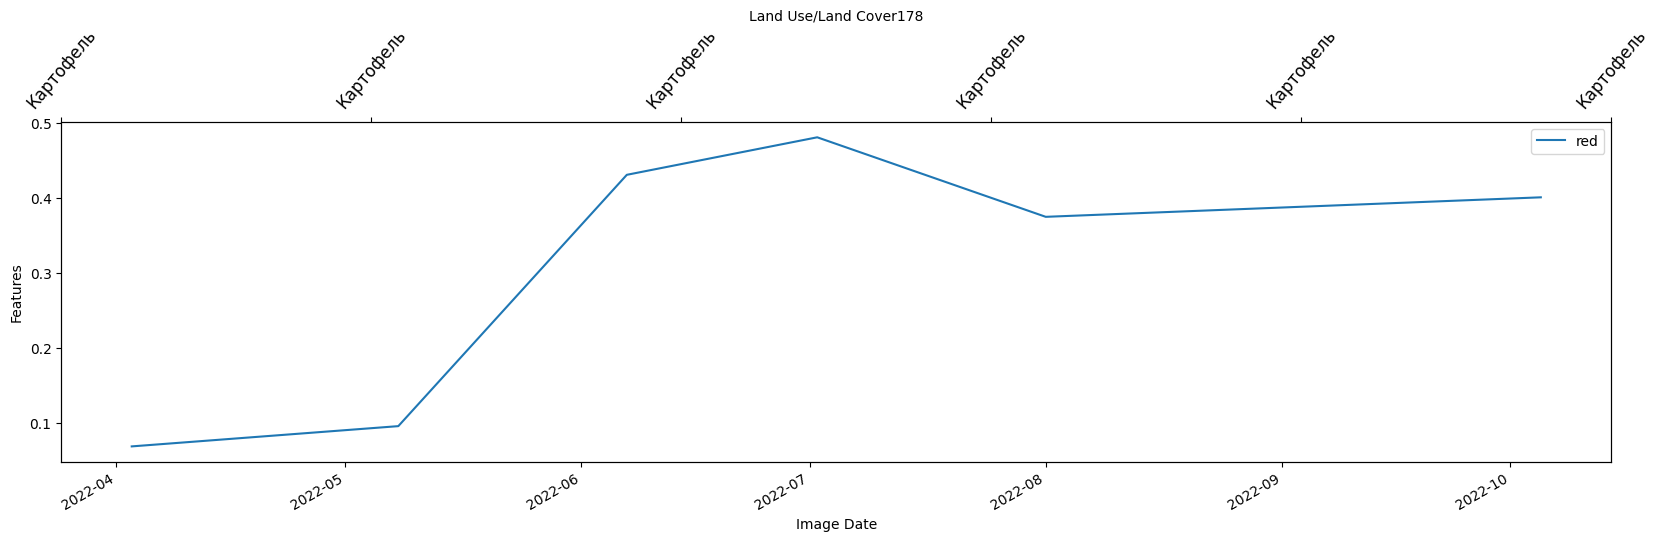

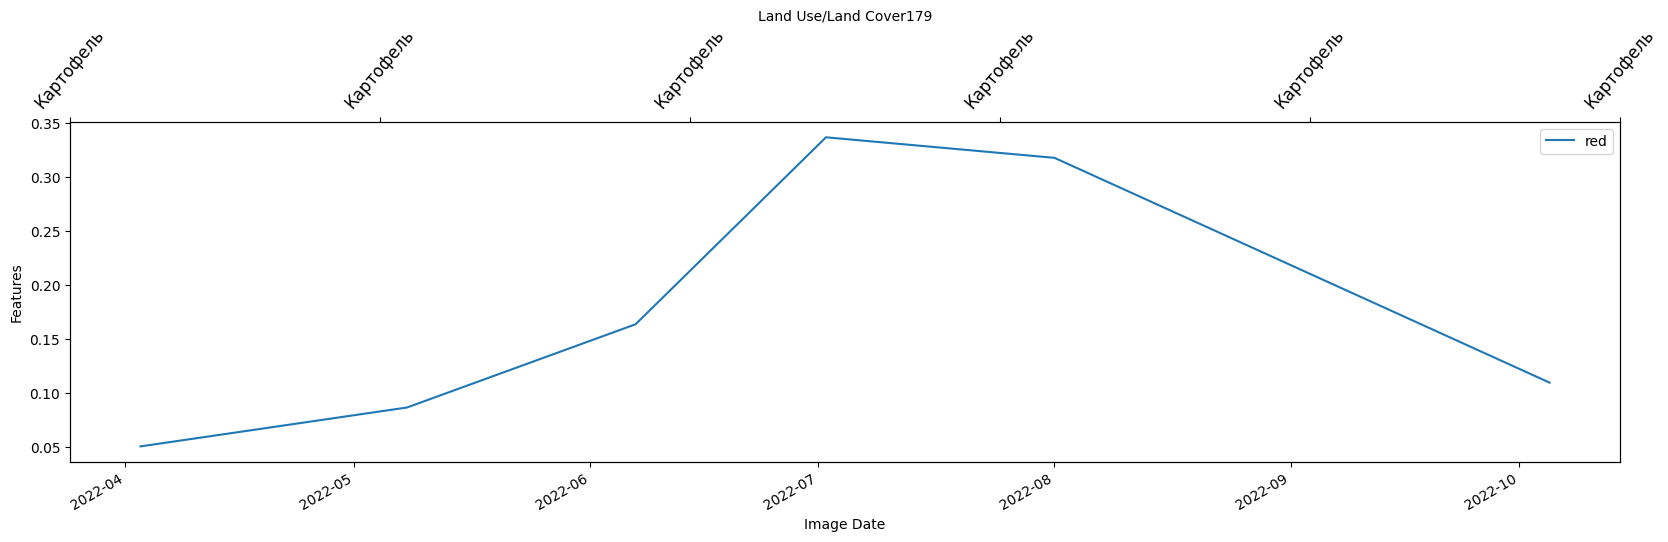

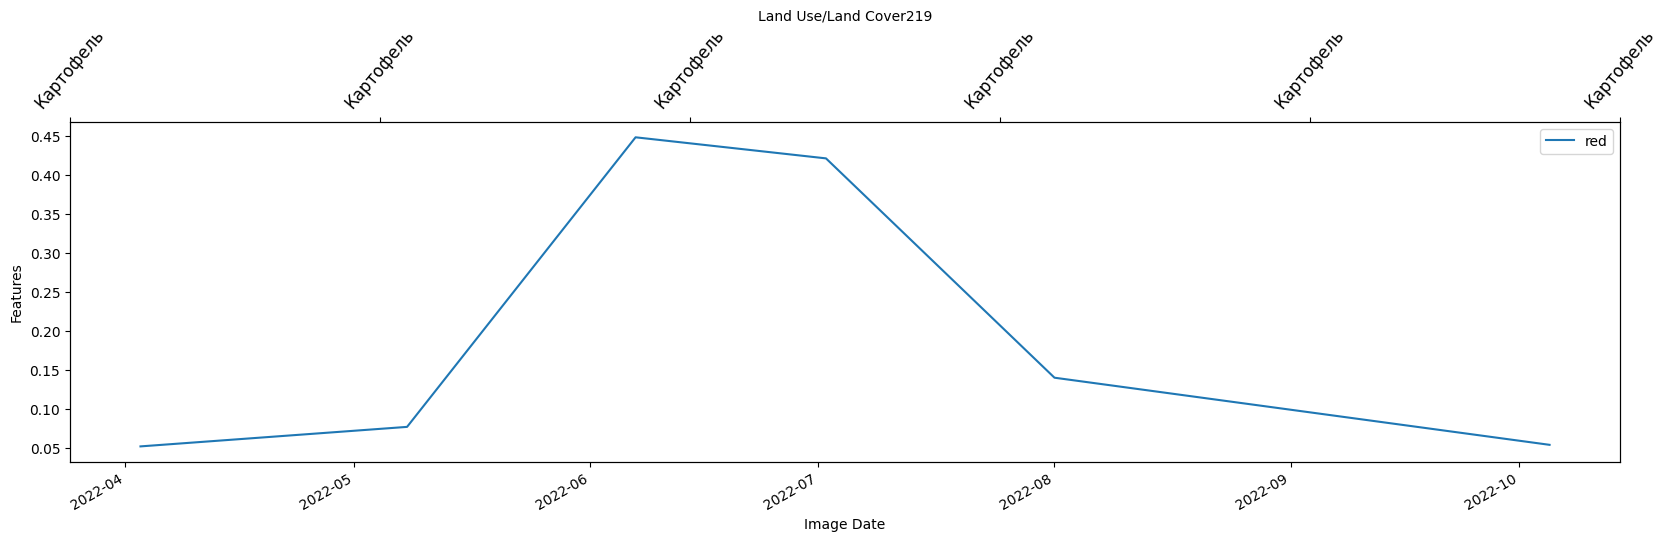

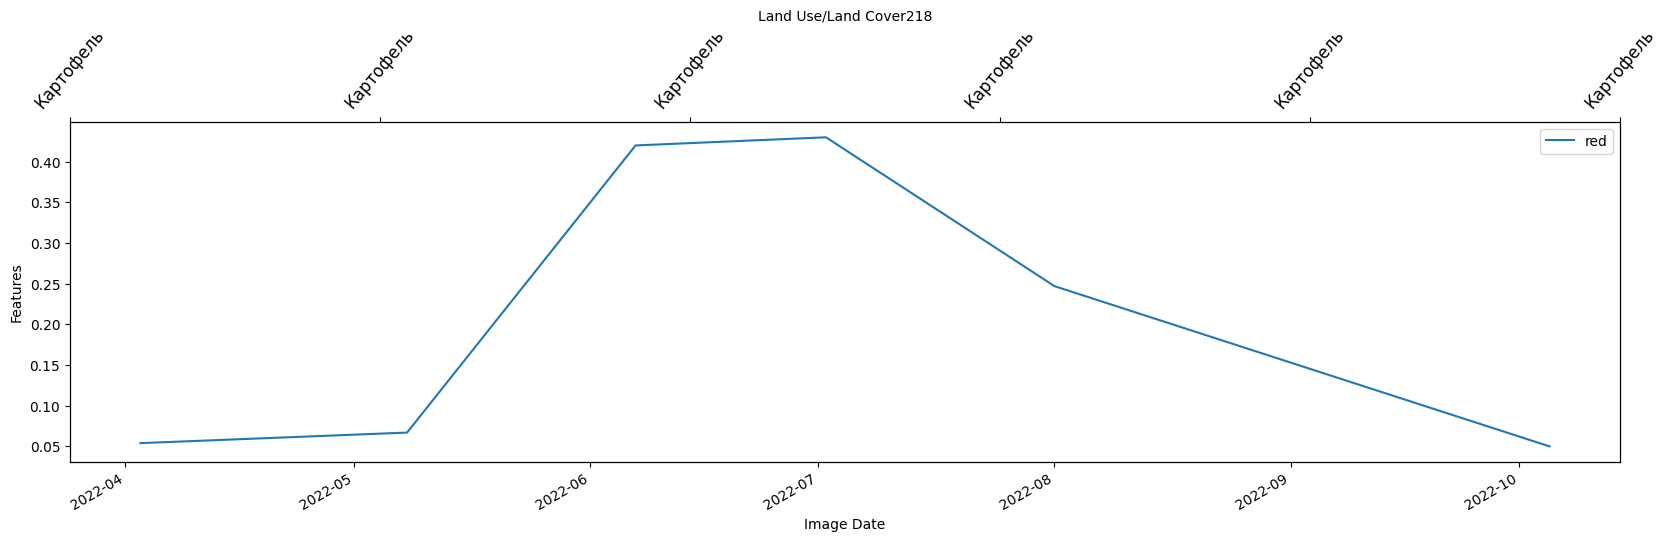

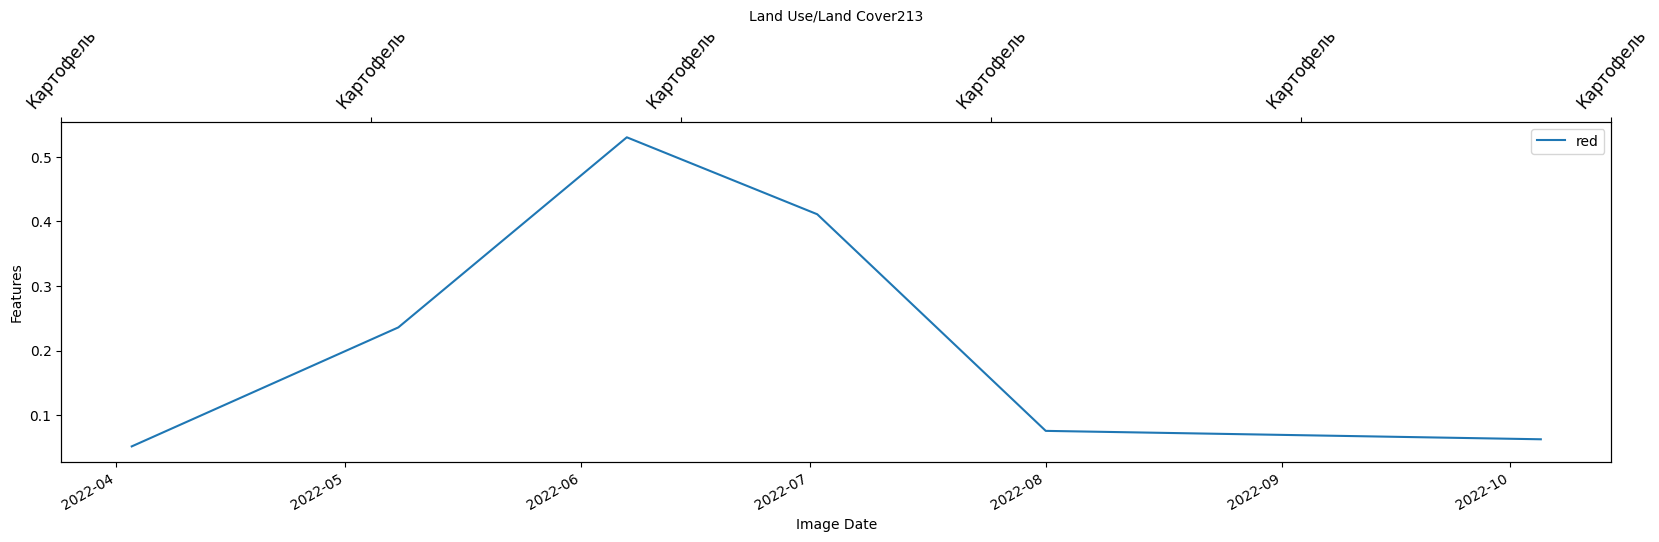

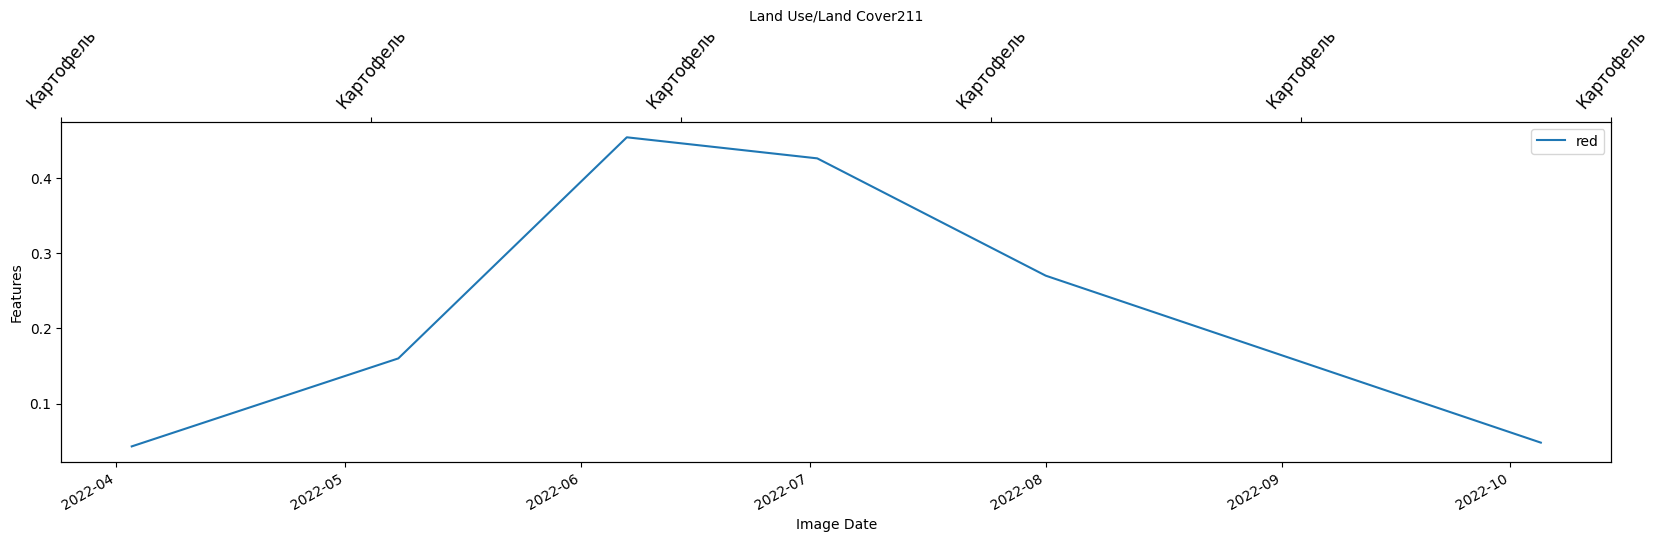

In [33]:
# points = df2.id.unique()

for point in points:
    point_df2 = df2[df2['id'] == point]
    point_df2 = point_df2.sort_values(by=['date'])
    ax = point_df2.plot(x='date', y=features, figsize=(20, 5))

    axes1 = plt.gca()
    axes2 = axes1.twiny()
    
    class_names = point_df2['class_name'].tolist()
    axes2.set_xticks(np.arange(len(class_names)))
    axes2.set_xticklabels(class_names, rotation=50, fontsize=12, minor=False)

    axes1.set_ylabel("Features")
    axes1.set_xlabel("Image Date")
    axes2.set_xlabel(f"Land Use/Land Cover{point}")

In [ ]:
# df2 = df2.drop(columns=['class_name'])

In [ ]:
df2

In [ ]:
df2.to_csv('alast_dataset_rready.csv')

In [ ]:
X = []
y = []

for point in points:
    point_df2 = df2[df2['id'] == point]
    point_df2 = point_df2.sort_values(by=['date'])
    
    x_values = point_df2[features].to_numpy()
    y_values = point_df2['class'].tolist()

    x_values = tf.keras.preprocessing.sequence.pad_sequences([x_values], 
                                                             maxlen=sequence_size, dtype='float32')[0]
    y_values = tf.keras.preprocessing.sequence.pad_sequences([y_values], 
                                                             maxlen=sequence_size, 
                                                             value=classes.get('not identified'), dtype='float32')[0]
    
    X.append(x_values)
    
    labels = []
    placeholder_value = -1  # or any other value that you see fit and not already in use
    for y_value in y_values:
        if np.isnan(y_value):
           y_value = placeholder_value
        values = np.zeros(len(classes))
        np.put(values, [int(y_value)], [1])
        labels.append(values)

        
    y.append(labels)
    
X = np.array(X)
y = np.array(y)

X = X.reshape((X.shape[0], X.shape[1], n_features))

X.shape, y.shape

In [ ]:
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2)
X_validation, X_test, y_validation, y_test = train_test_split(X_validation, y_validation, test_size=0.5)

print("Train: ", len(X_train), "\nValidation: ", len(X_validation), "\nTest:", len(X_test))

In [ ]:
X_train.shape, y_train.shape


In [ ]:
def LSTM(n_classes, sequence_size, n_features):
    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.LSTM(200, input_shape=(sequence_size, n_features)))
    
    model.add(tf.keras.layers.RepeatVector(sequence_size))
    
    model.add(tf.keras.layers.LSTM(200, activation='relu', return_sequences=True))
    
    model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(100, activation='relu')))

    model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_classes)))
    
    model.add(tf.keras.layers.Activation('softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model
              
model = LSTM(n_classes=len(classes), sequence_size=sequence_size, n_features=n_features)
              
model.summary()

tf.keras.utils.plot_model(model, show_shapes=True, to_file='./model.png')

In [ ]:
checkpoint_path = "{dir}/model.ckpt".format(dir=model_dir)

latest = tf.train.latest_checkpoint(model_dir)

if latest:
    model.load_weights(latest)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, save_best_only=True)

es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto', 
                                            baseline=None, restore_best_weights=True)

callbacks = [cp_callback, es_callback]

In [ ]:
epochs = 100
batch_size = 128

history = model.fit(x=X_train, y=y_train, 
          validation_data=(X_validation, y_validation),
          epochs=epochs, batch_size=batch_size, callbacks=callbacks, verbose=1)

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(15, 10))

# Plotting loss
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="Validation loss")
ax[0].legend(loc='best', shadow=True)

# Plotting accuracy
ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r', label="Validation accuracy")
ax[1].legend(loc='best', shadow=True)

plt.show()

In [ ]:
model.evaluate(X_test, y_test, batch_size=128)


In [ ]:
model.save('model.h5')